In [1]:
#!pip install tensorflow --upgrade


In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
#Creiamo un tf.data.Dataset a partire dalle immagini nella directory su disco per il training set e il test set.
dir = 'train'
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    labels='inferred',
    label_mode='int'
)


Found 16932 files belonging to 4 classes.


In [4]:
dir = 'test'
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    labels='inferred',
    label_mode='int'
)



Found 4233 files belonging to 4 classes.


In [5]:
#Verifichiamo i nomi delle classi 
class_names = train_set.class_names
class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [6]:
#image_batch è un tensore della forma (32, 256, 256, 3) .
#Questo è un batch di 32 immagini di forma 256x256x3. 
#Il label_batch è un tensore della forma (32,4) cioè in ogni batch ci sono 32 immagini e le etichette sono 4
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 256, 256, 3)
(32,)


In [7]:
import numpy as np
#I valori del canale RGB sono nell'intervallo [0, 255].
#Verifichiamo ad esempio considerando la prima immagini del dataset.
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

10.166882 253.91602


Questo non è l'ideale per una rete neurale dato che occorre ridurre i valori di input, è possibile standardizzare i valori nell'intervallo [0, 1] utilizzando un livello di ridimensionamento nel modello del tipo: normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


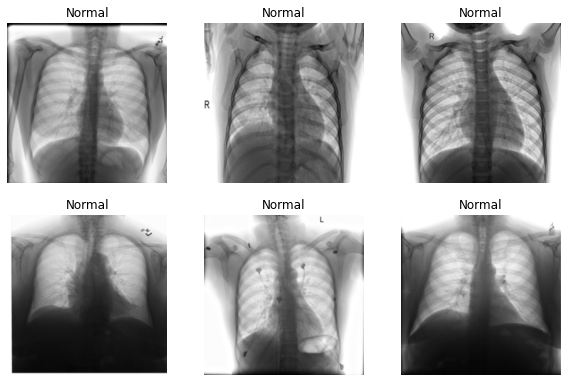

In [8]:
#Visualizziamo le prime 6 immagini del training set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
from keras.models import Sequential
from keras.layers import Dense

#Definiamo una semplice rete MLP con 3 strati fully-connected
num_classes = 4

def simple_MPL_model():
    #Scegliamo come funzione di attivazione degli hidden layers la LeakyRelu, dato che sperimentalmente si dimostra
    #prona all'overfitting, la usiamo insieme alla tecnica del dropout.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(8, activation=keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(8, activation=keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(8, activation=keras.layers.LeakyReLU(alpha=0.1)))
    #strato output
    model.add(tf.keras.layers.Dense(num_classes))
    return model

model = simple_MPL_model()

#Scegliamo come optimizer ADAM
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dropout (Dropout)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1572872   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 7

In [10]:
#Addestriamo il modello definito 
epochs=5
history = model.fit(
    train_set,
    epochs=epochs
)


Epoch 1/5
530/530 [==============================] - 108s 200ms/step - loss: 1.7367 - accuracy: 0.4419
Epoch 2/5
530/530 [==============================] - 100s 187ms/step - loss: 1.0700 - accuracy: 0.5327
Epoch 3/5
530/530 [==============================] - 79s 147ms/step - loss: 1.0081 - accuracy: 0.5657
Epoch 4/5
530/530 [==============================] - 79s 148ms/step - loss: 0.9344 - accuracy: 0.6007
Epoch 5/5
530/530 [==============================] - 77s 145ms/step - loss: 0.9134 - accuracy: 0.6119


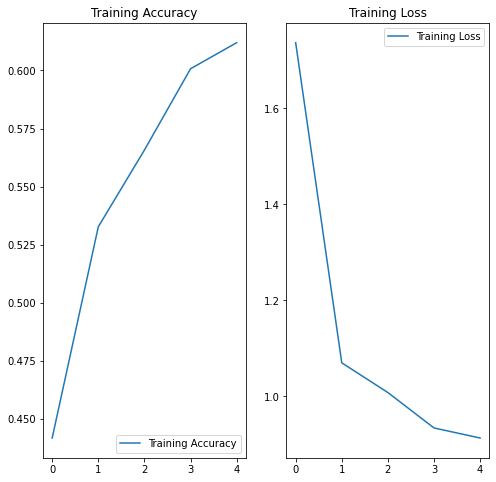

In [11]:
#Verifichiamo le prestazioni del modello durante il training
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


In [ ]:
result = model.evaluate(test_set)
result